In [96]:
import sys
import pandas as pd
import numpy as np
from pathlib import Path
import tarfile
import urllib.request
from packaging import version
import sklearn
import ast
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
pio.renderers.default = "notebook"
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn
from torch.nn import functional as F
from pytorch_lightning import Trainer
import logging
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import optuna
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, accuracy_score
assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")


### Load data

In [2]:
test_set = pd.read_csv("/Users/sheidamajidi/Desktop/Winter2024/Winter2024-2/MGSC673/Assignments/Project/house_price_prediction/data/test.csv")
train_set= pd.read_csv("/Users/sheidamajidi/Desktop/Winter2024/Winter2024-2/MGSC673/Assignments/Project/house_price_prediction/data/train.csv")

### 1 - Exploration Data Analysis (EDA)

In [3]:
# basic information and summary
print("Training Set Info:")
print(train_set.info())
print("\nTesting Set Info:")
print(test_set.info())


Training Set Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   in

In [4]:
# missing values
print("\nMissing Values in Training Set:")
print(train_set.isnull().sum())

print("\nMissing Values in Testing Set:")
print(test_set.isnull().sum())


Missing Values in Training Set:
Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

Missing Values in Testing Set:
Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64


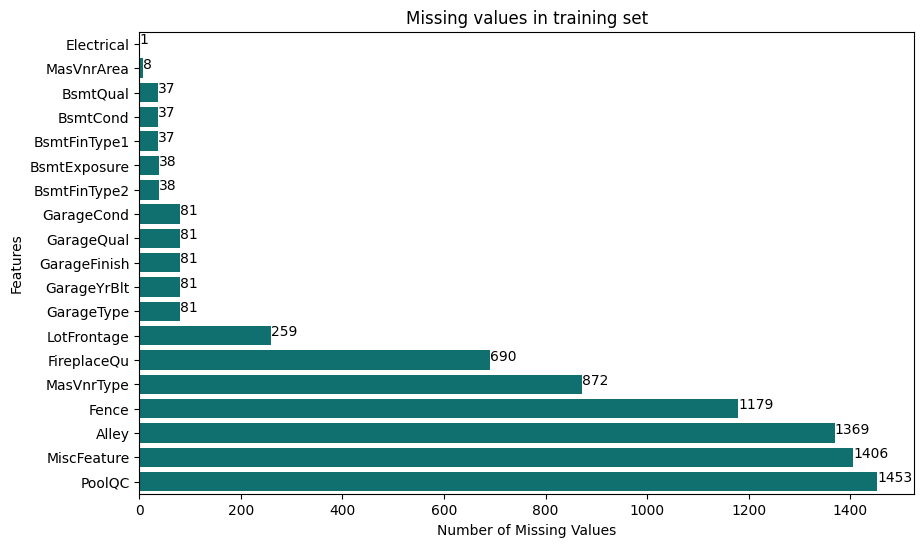

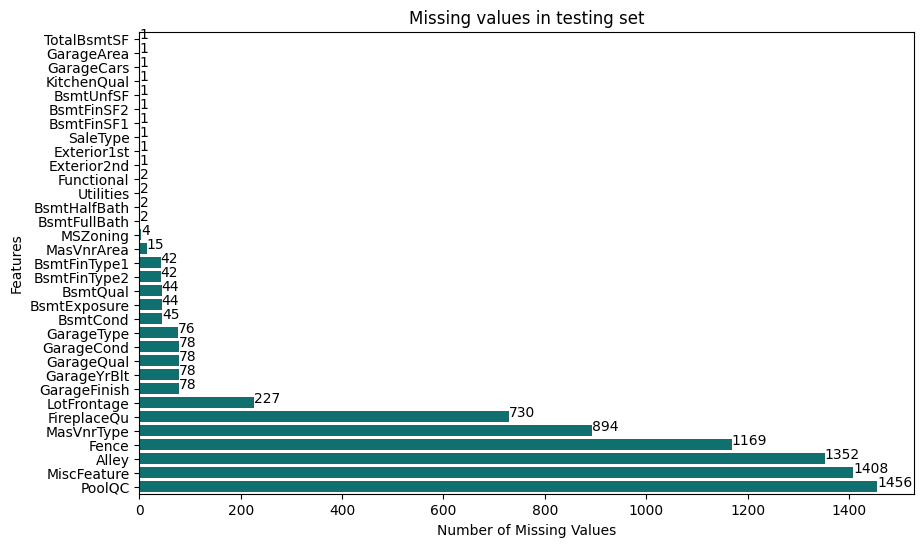

In [5]:
def plot_missing_values(dataframe, title):
    missing_data = dataframe.isnull().sum()
    missing_data = missing_data[missing_data > 0].sort_values(ascending=True)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(y=missing_data.index, x=missing_data.values, color='teal')
    plt.title(title)
    plt.xlabel('Number of Missing Values')
    plt.ylabel('Features')
    
    for index, value in enumerate(missing_data.values):
        plt.text(value, index, str(value))
    
    plt.show()

# missing values for both datasets
plot_missing_values(train_set, 'Missing values in training set')
plot_missing_values(test_set, 'Missing values in testing set')

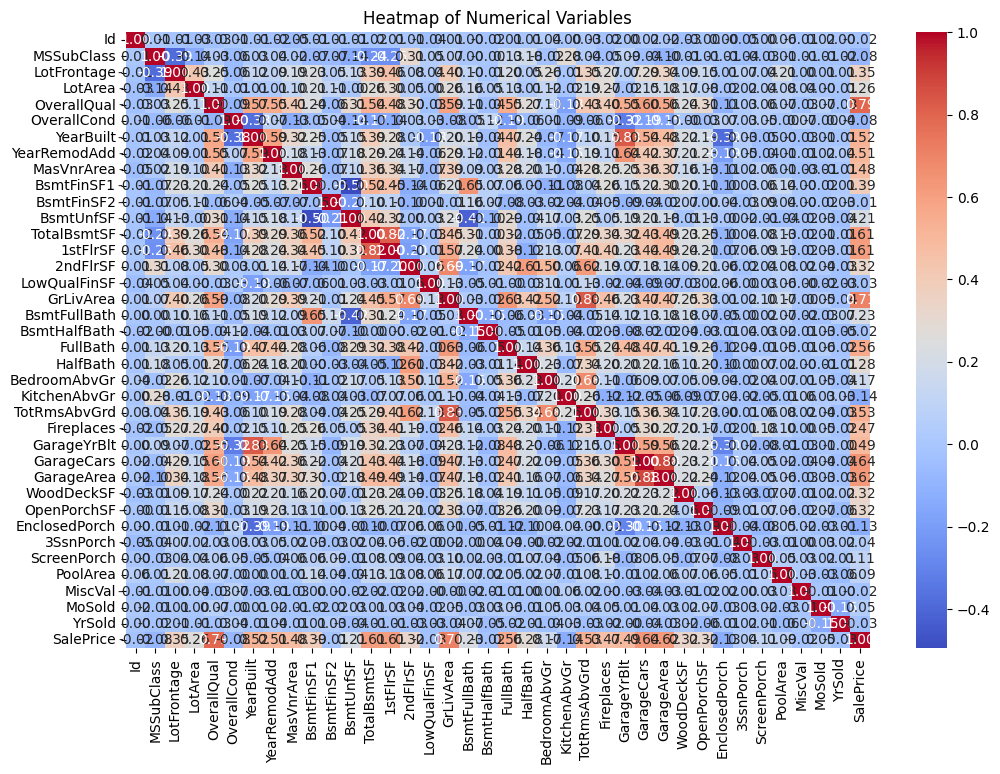

In [6]:
# correlation matrix
numerical_cols = train_set.select_dtypes(include=['int64', 'float64']).columns.tolist()
corr_matrix = train_set[numerical_cols].corr()

# heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Heatmap of Numerical Variables')
plt.show()

#### Data visualization for distribution

In [7]:
# Histogram of SalePrice for distribution
fig = px.histogram(train_set, x='SalePrice', title='Distribution of Sale Prices')
fig.show()


##### Bi-variate and Multi-variate analysis

In [8]:
# Checking for relationships between Overall Quality, Year Built, and Sale Price
fig = px.scatter(train_set, x='OverallQual', y='SalePrice', color='YearBuilt', title='Sale price vs overall quality (colored by year built)')
fig.show()

In [9]:
# Analyzing how living area and lot area impact Sale Price and House Category
fig = px.scatter(train_set, x='GrLivArea', y='SalePrice', size='LotArea', title='Sale price vs living area with lot area as size')
fig.show()

In [10]:
# Analyzing categorical data impact on sale price

# Transforming 'MSSubClass' to string type to treat it as a categorical feature
train_set['MSSubClass'] = train_set['MSSubClass'].astype(str)
fig = px.box(train_set, x='MSSubClass', y='SalePrice', title='Sale price distribution across different building classes')
fig.show()

In [11]:
## Handle missing values
# Separate numerical and categorical columns
numerical_cols = train_set.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = train_set.select_dtypes(include=['object']).columns.tolist()

# Advanced imputation for numerical columns with KNN
knn_imputer = KNNImputer(n_neighbors=5)
train_set[numerical_cols] = knn_imputer.fit_transform(train_set[numerical_cols])

# Imputation for categorical columns using the most frequent category
for column in categorical_cols:
    freq_imputer = SimpleImputer(strategy='most_frequent')
    train_set[column] = pd.DataFrame(freq_imputer.fit_transform(train_set[[column]]))

# Multi-variate analysis with house style, overall quality, and sale price
fig = px.scatter(train_set, x='OverallQual', y='SalePrice', size='LotFrontage', color='HouseStyle', title='House style, quality, and sale price relationship')
fig.show()

In [12]:
# Relationship between Neighborhood and Sale Price
fig = px.box(train_set, x='Neighborhood', y='SalePrice', title='Sale price across neighborhoods')
fig.update_traces(quartilemethod="inclusive")
fig.show()

### 2 - MultiTask Model Building

In [4]:
# Feature Engineering
train_set['HouseAge'] = train_set['YrSold'] - train_set['YearBuilt']
train_set['RemodAge'] = train_set['YrSold'] - train_set['YearRemodAdd']
train_set['HouseCategory'] = (train_set['BldgType'] + '_' + 
                              pd.cut(train_set['HouseAge'], bins=2, labels=['New', 'Old']).astype(str) + 
                              '_' + pd.cut(train_set['RemodAge'], bins=2, labels=['Recent', 'Oldest']).astype(str))


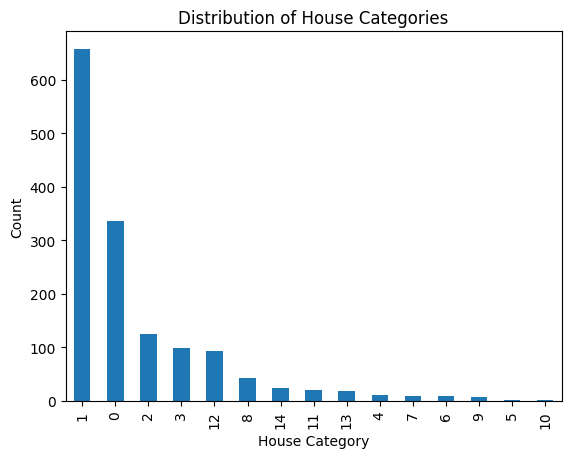

In [52]:
# Plotting the value counts for 'HouseCategory'
train_set['HouseCategory'].value_counts().plot(kind='bar')
plt.xlabel('House Category')
plt.ylabel('Count')
plt.title('Distribution of House Categories')
plt.show()

In [14]:
# Encode 'HouseCategory'
encoder = LabelEncoder()
train_set['HouseCategory'] = encoder.fit_transform(train_set['HouseCategory'])

# Prepare data for modeling
y = train_set[['SalePrice', 'HouseCategory']]
x = train_set.drop(columns=['SalePrice', 'HouseCategory'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)
x_fit, x_val, y_fit, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=123)

### Preprocessing Pipeline

In [15]:
# Preprocessing
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
)

categorical_transformer = Pipeline([
    ("imputer_cat", SimpleImputer(strategy='most_frequent')),
    ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

# Define columns after feature engineering to avoid 'HouseCategory' issue
numerical_cols = x.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = x.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols),
])

# Final pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("scaler", MinMaxScaler())
])

# Apply transformations
x_fit_preprocessed = pipeline.fit_transform(x_fit)
x_val_preprocessed = pipeline.transform(x_val)
x_test_preprocessed = pipeline.transform(x_test)


In [16]:
class MultiTaskHouseModel(pl.LightningModule):
    def __init__(self, input_features, num_classes, activation_fn=nn.ReLU(), optimizer_type='Adam', lr=0.01, initial_neurons = 256):
        super().__init__()
        self.activation_fn = activation_fn
        self.optimizer_type = optimizer_type
        self.lr = lr
        self.initial_neurons = initial_neurons
        self.shared_layers = nn.Sequential(
            nn.Linear(input_features, initial_neurons),
            self.activation_fn,
            nn.Linear(initial_neurons, 128),  
            self.activation_fn,
            nn.Linear(128, 64),  
            self.activation_fn,
            nn.Linear(64, 32), 
            self.activation_fn
        )
        
        self.price_head = nn.Linear(32, 1)  
        self.category_head = nn.Linear(32, num_classes)  

        # Loss functions
        self.regression_loss = nn.MSELoss()
        self.classification_loss = nn.CrossEntropyLoss()

    def forward(self, x):
        shared_output = self.shared_layers(x)
        price = self.price_head(shared_output)
        category = self.category_head(shared_output)
        return price, category

    def training_step(self, batch, batch_idx):
        x, y_price, y_category = batch
        pred_price, pred_category = self(x)
        
        loss_price = self.regression_loss(pred_price.squeeze(), y_price)
        loss_category = self.classification_loss(pred_category, y_category)
        total_loss = loss_price + loss_category 
        self.log('train_loss', total_loss)
        return total_loss

    def validation_step(self, batch, batch_idx):
        x, y_price, y_category = batch
        pred_price, pred_category = self(x)
        loss_price = self.regression_loss(pred_price.squeeze(), y_price)
        loss_category = self.classification_loss(pred_category, y_category)
        total_loss = loss_price + loss_category  
        self.log('val_loss', total_loss)
        return {'val_loss': total_loss}
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x = batch[0]
        pred_price, pred_category = self(x)
        pred_category_prob = F.softmax(pred_category, dim=1) 
        return pred_price, pred_category_prob

    def configure_optimizers(self):
        if self.optimizer_type == 'Adam':
            return torch.optim.Adam(self.parameters(), lr=self.lr)
        elif self.optimizer_type == 'SGD':
            return torch.optim.SGD(self.parameters(), lr=self.lr, momentum=0.9)  
        elif self.optimizer_type == 'RMSprop':
            return torch.optim.RMSprop(self.parameters(), lr=self.lr)
        else:
            raise ValueError("Unsupported optimizer type")


In [17]:
train_dataset = TensorDataset(torch.tensor(x_fit_preprocessed, dtype=torch.float),
                              torch.tensor(y_fit['SalePrice'].values, dtype=torch.float),
                              torch.tensor(y_fit['HouseCategory'].values, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(torch.tensor(x_val_preprocessed, dtype=torch.float),
                            torch.tensor(y_val['SalePrice'].values, dtype=torch.float),
                            torch.tensor(y_val['HouseCategory'].values, dtype=torch.long))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(torch.tensor(x_test_preprocessed, dtype=torch.float))
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [18]:
model = MultiTaskHouseModel(input_features=x_fit_preprocessed.shape[1], num_classes=len(y_fit['HouseCategory'].unique()), optimizer_type='Adam')
trainer = Trainer(max_epochs=100)
trainer.fit(model, train_loader, val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params
---------------------------------------------------------
0 | activation_fn       | ReLU             | 0     
1 | shared_layers       | Sequential       | 64.5 K
2 | price_head          | Linear           | 33    
3 | category_head       | Linear           | 495   
4 | regression_loss     | MSELoss          | 0     
5 | classification_loss | CrossEntropyLoss | 0     
---------------------------------------------------------
65.0 K    Trainable params
0         Non-trainable params
65.0 K    Total params
0.260     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/sheidamajidi/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/sheidamajidi/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/sheidamajidi/anaconda3/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [19]:
# metrics for the model
def get_metrics(trainer, model, test_loader, y_test):
    total_preds = trainer.predict(model, dataloaders=test_loader)[0]
    mae = mean_absolute_error(total_preds[0], y_test['SalePrice'])
    mape = mean_absolute_percentage_error(total_preds[0], y_test['SalePrice'])
    classification_preds = []
    for i in total_preds[1]:
        classification_preds.append(np.argmax(i))
    accuracy = accuracy_score(classification_preds, y_test['HouseCategory'])
    metrics = {'mae': mae, 'mape': mape, 'accuracy': accuracy}
    return metrics

In [20]:
metrics = get_metrics(trainer, model, test_loader, y_test)

# Printing the metrics
print("Validation Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

/Users/sheidamajidi/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Validation Metrics:
mae: 16707.4683
mape: 0.0930
accuracy: 0.4486


### 3 - Activation Function and Optimizers

In [21]:
# Activation functions and their names
activation_functions = [nn.ReLU(), nn.LeakyReLU(), nn.ELU(), nn.Sigmoid()]
activation_names = ['ReLU', 'LeakyReLU', 'ELU', 'Sigmoid']

# Optimizer dictionary with the corresponding optimizer classes
optimizers = {
    'Adam': torch.optim.Adam,
    'SGD': torch.optim.SGD,
    'RMSprop': torch.optim.RMSprop
}

In [51]:
class MultiTaskHouseModel(pl.LightningModule):
    def __init__(self, input_features, num_classes, activation_fn=nn.ReLU(), optimizer_class=torch.optim.Adam, lr=0.01, initial_neurons=256):
        super().__init__()
        self.save_hyperparameters()
        self.activation_fn = activation_fn
        self.optimizer_class = optimizer_class
        self.lr = lr
        self.initial_neurons = initial_neurons
        self.shared_layers = nn.Sequential(
            nn.Linear(input_features, initial_neurons),
            self.activation_fn,
            nn.Linear(initial_neurons, 128),
            self.activation_fn,
            nn.Linear(128, 64),
            self.activation_fn,
            nn.Linear(64, 32),
            self.activation_fn
        )
        self.price_head = nn.Linear(32, 1)
        self.category_head = nn.Linear(32, num_classes)

    def forward(self, x):
        shared_output = self.shared_layers(x)
        price_output = self.price_head(shared_output)
        category_output = self.category_head(shared_output)
        return price_output, category_output

    def training_step(self, batch, batch_idx):
        x, y_price, y_category = batch
        pred_price, pred_category = self(x)
        loss_price = self.regression_loss(pred_price.squeeze(), y_price)
        loss_category = self.classification_loss(pred_category, y_category)
        total_loss = loss_price + loss_category
        self.log('train_loss', total_loss)
        return total_loss

    def test_step(self, batch, batch_idx):
        if len(batch) == 2 and isinstance(batch[1], tuple):  # Checks if labels are included
            x, (y_price, y_category) = batch
            pred_price, pred_category = self(x)
            loss_price = self.regression_loss(pred_price.squeeze(), y_price)
            loss_category = self.classification_loss(pred_category, y_category)
            loss = loss_price + loss_category
            self.log('test_loss', loss)
            return {'test_loss': loss}
        else:
            x = batch
            pred_price, pred_category = self(x)
            # Only calculate predictions without calculating loss
            return {'predictions': (pred_price, pred_category)}


    def regression_loss(self, pred, target):
        return nn.MSELoss()(pred, target)

    def classification_loss(self, pred, target):
        return nn.CrossEntropyLoss()(pred, target)

    def configure_optimizers(self):
        return self.optimizer_class(self.parameters(), lr=self.lr)


In [61]:
# Function to run the experiments
def run_experiments(activation_funcs, activation_names, optimizers, epochs=50):
    final_metrics = {}
    
    for activation, activation_name in zip(activation_funcs, activation_names):
        for opt_name, opt_class in optimizers.items():
            experiment_name = f"{activation_name}_{opt_name}"
            print(f"Running experiment: {experiment_name}")
            
            try:
                model = MultiTaskHouseModel(
                    input_features=x_fit_preprocessed.shape[1], 
                    num_classes=len(y_fit['HouseCategory'].unique()),
                    activation_fn=activation, 
                    optimizer_class=opt_class, 
                    lr=0.001
                )
                
                trainer = pl.Trainer(max_epochs=epochs)
                trainer.fit(model, train_loader, val_loader)
                
                # Optionally, you can test the model here and save the results
                test_result = trainer.test(model, test_loader)
                final_metrics[experiment_name] = test_result
                print(f"Completed experiment: {experiment_name}")
                
            except Exception as e:
                print(f"Error in experiment {experiment_name}: {e}")
                final_metrics[experiment_name] = str(e)

    return final_metrics

# Run experiments
experiment_results = run_experiments(activation_functions, activation_names, optimizers)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params
---------------------------------------------
0 | activation_fn | ReLU       | 0     
1 | shared_layers | Sequential | 64.5 K
2 | price_head    | Linear     | 33    
3 | category_head | Linear     | 495   
---------------------------------------------
65.0 K    Trainable params
0         Non-trainable params
65.0 K    Total params
0.260     Total estimated model params size (MB)


Running experiment: ReLU_Adam


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
/Users/sheidamajidi/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params
---------------------------------------------
0 | activation_fn | ReLU       | 0     
1 | shared_layers | Sequential | 64.5 K
2 | price_head    | Linear     | 33    
3 | category_head | Linear     | 495   
---------------------------------------------
65.0 K    Trainable params
0         Non-trainable params
65.0 K    Total params
0.260     Total estimated model params size (MB)


Error in experiment ReLU_Adam: linear(): argument 'input' (position 1) must be Tensor, not list
Running experiment: ReLU_SGD


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params
---------------------------------------------
0 | activation_fn | ReLU       | 0     
1 | shared_layers | Sequential | 64.5 K
2 | price_head    | Linear     | 33    
3 | category_head | Linear     | 495   
---------------------------------------------
65.0 K    Trainable params
0         Non-trainable params
65.0 K    Total params
0.260     Total estimated model params size (MB)


Error in experiment ReLU_SGD: linear(): argument 'input' (position 1) must be Tensor, not list
Running experiment: ReLU_RMSprop


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params
---------------------------------------------
0 | activation_fn | LeakyReLU  | 0     
1 | shared_layers | Sequential | 64.5 K
2 | price_head    | Linear     | 33    
3 | category_head | Linear     | 495   
---------------------------------------------
65.0 K    Trainable params
0         Non-trainable params
65.0 K    Total params
0.260     Total estimated model params size (MB)


Error in experiment ReLU_RMSprop: linear(): argument 'input' (position 1) must be Tensor, not list
Running experiment: LeakyReLU_Adam


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params
---------------------------------------------
0 | activation_fn | LeakyReLU  | 0     
1 | shared_layers | Sequential | 64.5 K
2 | price_head    | Linear     | 33    
3 | category_head | Linear     | 495   
---------------------------------------------
65.0 K    Trainable params
0         Non-trainable params
65.0 K    Total params
0.260     Total estimated model params size (MB)


Error in experiment LeakyReLU_Adam: linear(): argument 'input' (position 1) must be Tensor, not list
Running experiment: LeakyReLU_SGD


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params
---------------------------------------------
0 | activation_fn | LeakyReLU  | 0     
1 | shared_layers | Sequential | 64.5 K
2 | price_head    | Linear     | 33    
3 | category_head | Linear     | 495   
---------------------------------------------
65.0 K    Trainable params
0         Non-trainable params
65.0 K    Total params
0.260     Total estimated model params size (MB)


Error in experiment LeakyReLU_SGD: linear(): argument 'input' (position 1) must be Tensor, not list
Running experiment: LeakyReLU_RMSprop


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params
---------------------------------------------
0 | activation_fn | ELU        | 0     
1 | shared_layers | Sequential | 64.5 K
2 | price_head    | Linear     | 33    
3 | category_head | Linear     | 495   
---------------------------------------------
65.0 K    Trainable params
0         Non-trainable params
65.0 K    Total params
0.260     Total estimated model params size (MB)


Error in experiment LeakyReLU_RMSprop: linear(): argument 'input' (position 1) must be Tensor, not list
Running experiment: ELU_Adam


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params
---------------------------------------------
0 | activation_fn | ELU        | 0     
1 | shared_layers | Sequential | 64.5 K
2 | price_head    | Linear     | 33    
3 | category_head | Linear     | 495   
---------------------------------------------
65.0 K    Trainable params
0         Non-trainable params
65.0 K    Total params
0.260     Total estimated model params size (MB)


Error in experiment ELU_Adam: linear(): argument 'input' (position 1) must be Tensor, not list
Running experiment: ELU_SGD


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params
---------------------------------------------
0 | activation_fn | ELU        | 0     
1 | shared_layers | Sequential | 64.5 K
2 | price_head    | Linear     | 33    
3 | category_head | Linear     | 495   
---------------------------------------------
65.0 K    Trainable params
0         Non-trainable params
65.0 K    Total params
0.260     Total estimated model params size (MB)


Error in experiment ELU_SGD: linear(): argument 'input' (position 1) must be Tensor, not list
Running experiment: ELU_RMSprop


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params
---------------------------------------------
0 | activation_fn | Sigmoid    | 0     
1 | shared_layers | Sequential | 64.5 K
2 | price_head    | Linear     | 33    
3 | category_head | Linear     | 495   
---------------------------------------------
65.0 K    Trainable params
0         Non-trainable params
65.0 K    Total params
0.260     Total estimated model params size (MB)


Error in experiment ELU_RMSprop: linear(): argument 'input' (position 1) must be Tensor, not list
Running experiment: Sigmoid_Adam


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params
---------------------------------------------
0 | activation_fn | Sigmoid    | 0     
1 | shared_layers | Sequential | 64.5 K
2 | price_head    | Linear     | 33    
3 | category_head | Linear     | 495   
---------------------------------------------
65.0 K    Trainable params
0         Non-trainable params
65.0 K    Total params
0.260     Total estimated model params size (MB)


Error in experiment Sigmoid_Adam: linear(): argument 'input' (position 1) must be Tensor, not list
Running experiment: Sigmoid_SGD


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params
---------------------------------------------
0 | activation_fn | Sigmoid    | 0     
1 | shared_layers | Sequential | 64.5 K
2 | price_head    | Linear     | 33    
3 | category_head | Linear     | 495   
---------------------------------------------
65.0 K    Trainable params
0         Non-trainable params
65.0 K    Total params
0.260     Total estimated model params size (MB)


Error in experiment Sigmoid_SGD: linear(): argument 'input' (position 1) must be Tensor, not list
Running experiment: Sigmoid_RMSprop


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

Error in experiment Sigmoid_RMSprop: linear(): argument 'input' (position 1) must be Tensor, not list


##### Quick debugging

In [62]:
# Debugging line to check input type
def forward(self, x):
    print(f"Input type: {type(x)}") 
    shared_output = self.shared_layers(x)
    price = self.price_head(shared_output)
    category = self.category_head(shared_output)
    return price, category


In [74]:
test_dataset = TensorDataset(torch.tensor(x_test_preprocessed, dtype=torch.float),
                             torch.tensor(y_test['SalePrice'].values, dtype=torch.float),
                             torch.tensor(y_test['HouseCategory'].values, dtype=torch.long))

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [75]:
# Quick check to see what the test_loader is producing
for data in test_loader:
    print(data)
    break  # Break after printing the first batch to see the structure


[tensor([[0.1008, 0.2353, 0.3170,  ..., 0.5000, 1.0000, 0.8000],
        [0.4633, 0.2941, 0.2549,  ..., 0.5000, 1.0000, 0.8000],
        [0.8938, 0.8235, 0.0719,  ..., 0.5000, 1.0000, 0.8000],
        ...,
        [0.5291, 0.3529, 0.4771,  ..., 0.5000, 1.0000, 0.0000],
        [0.0212, 0.0000, 0.3170,  ..., 0.5000, 1.0000, 0.8000],
        [0.6669, 0.0000, 0.4837,  ..., 0.5000, 0.7500, 1.0000]]), tensor([222500.,  87000., 130000., 274300., 140000., 259000., 309000., 127500.,
        155000., 147000., 159000., 220000., 140000., 108000., 260000., 207500.,
        115000., 325624., 212000., 167900., 151000., 162900., 109500., 143000.,
        230000., 145000., 208900., 181000., 129900., 107000., 149350., 182000.]), tensor([ 1,  2, 12,  1,  0,  1,  1,  8,  0,  1,  1,  1, 12,  0,  1,  1,  1,  1,
         1,  0,  0,  0,  0,  3,  1,  1,  1,  1,  0,  0,  1,  1])]


In [76]:
class MultiTaskHouseModel(pl.LightningModule):
    def __init__(self, input_features, num_classes, activation_fn=nn.LeakyReLU(), optimizer_class=torch.optim.Adam, lr=0.001):
        super().__init__()
        self.save_hyperparameters()
        self.activation_fn = activation_fn
        self.shared_layers = nn.Sequential(
            nn.Linear(input_features, 256),
            self.activation_fn,
            nn.Linear(256, 128),  
            self.activation_fn,
            nn.Linear(128, 64),  
            self.activation_fn,
            nn.Linear(64, 32), 
            self.activation_fn
        )
        self.price_head = nn.Linear(32, 1)
        self.category_head = nn.Linear(32, num_classes)
        self.regression_loss = nn.MSELoss()
        self.classification_loss = nn.CrossEntropyLoss()

    def forward(self, x):
        shared_output = self.shared_layers(x)
        price = self.price_head(shared_output)
        category = self.category_head(shared_output)
        return price, category

    def training_step(self, batch, batch_idx):
        x, y_price, y_category = batch
        pred_price, pred_category = self(x)
        loss_price = self.regression_loss(pred_price.squeeze(), y_price)
        loss_category = self.classification_loss(pred_category, y_category)
        total_loss = loss_price + loss_category
        self.log('train_loss', total_loss)
        return total_loss

    def validation_step(self, batch, batch_idx):
        x, y_price, y_category = batch
        pred_price, pred_category = self(x)
        loss_price = self.regression_loss(pred_price.squeeze(), y_price)
        loss_category = self.classification_loss(pred_category, y_category)
        total_loss = loss_price + loss_category
        self.log('val_loss', total_loss)
        return {'val_loss': total_loss}

    def test_step(self, batch, batch_idx):
        x, y_price, y_category = batch 
        pred_price, pred_category = self(x)
        loss_price = self.regression_loss(pred_price.squeeze(), y_price)
        loss_category = self.classification_loss(pred_category, y_category)
        total_loss = loss_price + loss_category
        self.log('test_loss', total_loss)
        return {'test_loss': total_loss}


    def configure_optimizers(self):
        return self.hparams.optimizer_class(self.parameters(), lr=self.hparams.lr)

# Initialize the model
model = MultiTaskHouseModel(input_features=x_fit_preprocessed.shape[1], num_classes=len(y_fit['HouseCategory'].unique()), activation_fn=nn.LeakyReLU(), optimizer_class=torch.optim.Adam)

# Set up the trainer
trainer = pl.Trainer(max_epochs=50)

# Train the model
trainer.fit(model, train_loader, val_loader)

# Test the model
result = trainer.test(model, test_loader)

# Display the test results
print("Test Results:", result)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params
---------------------------------------------------------
0 | activation_fn       | LeakyReLU        | 0     
1 | shared_layers       | Sequential       | 64.5 K
2 | price_head          | Linear           | 33    
3 | category_head       | Linear           | 495   
4 | regression_loss     | MSELoss          | 0     
5 | classification_loss | CrossEntropyLoss | 0     
---------------------------------------------------------
65.0 K    Trainable params
0         Non-trainable params
65.0 K    Total params
0.260     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │        978542592.0        │
└───────────────────────────┴───────────────────────────┘

Test Results: [{'test_loss': 978542592.0}]


### 4, 5, 6 - Complete PyTorch Lightning Model Setup

In [77]:
class MultiTaskHouseModel(pl.LightningModule):
    def __init__(self, input_features, num_classes, activation_fn=nn.LeakyReLU(), optimizer_class=torch.optim.Adam, lr=0.001):
        super().__init__()
        self.save_hyperparameters()
        self.shared_layers = nn.Sequential(
            nn.Linear(input_features, 256),
            activation_fn,
            nn.Linear(256, 128),
            activation_fn,
            nn.Linear(128, 64),
            activation_fn,
            nn.Linear(64, 32),
            activation_fn
        )
        self.price_head = nn.Linear(32, 1)
        self.category_head = nn.Linear(32, num_classes)
        self.regression_loss = nn.MSELoss()
        self.classification_loss = nn.CrossEntropyLoss()

    def forward(self, x):
        shared_output = self.shared_layers(x)
        price = self.price_head(shared_output)
        category = self.category_head(shared_output)
        return price, category

    def training_step(self, batch, batch_idx):
        x, y_price, y_category = batch
        pred_price, pred_category = self(x)
        loss_price = self.regression_loss(pred_price.squeeze(), y_price)
        loss_category = self.classification_loss(pred_category, y_category)
        total_loss = loss_price + loss_category
        self.log('train_loss', total_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        x, y_price, y_category = batch
        pred_price, pred_category = self(x)
        loss_price = self.regression_loss(pred_price.squeeze(), y_price)
        loss_category = self.classification_loss(pred_category, y_category)
        total_loss = loss_price + loss_category
        self.log('val_loss', total_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'val_loss': total_loss}

    def test_step(self, batch, batch_idx):
        x, y_price, y_category = batch
        pred_price, pred_category = self(x)
        loss_price = self.regression_loss(pred_price.squeeze(), y_price)
        loss_category = self.classification_loss(pred_category, y_category)
        total_loss = loss_price + loss_category
        self.log('test_loss', total_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'test_loss': total_loss}

    def configure_optimizers(self):
        return self.hparams.optimizer_class(self.parameters(), lr=self.hparams.lr)


In [79]:
# Setup TensorBoard Logger
logger = pl_loggers.TensorBoardLogger('tb_logs', name='multi_task_model')

# Callback for model checkpointing
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='model_checkpoints',
    filename='multi_task_model-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min'
)

# Setup Trainer
trainer = Trainer(
    max_epochs=50,
    logger=logger,
    callbacks=[checkpoint_callback],
    enable_progress_bar=True
)

# Initialize the model
model = MultiTaskHouseModel(input_features=x_fit_preprocessed.shape[1], num_classes=len(y_fit['HouseCategory'].unique()))

# Training and validation
trainer.fit(model, train_loader, val_loader)

# Testing
trainer.test(model, test_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/multi_task_model

  | Name                | Type             | Params
---------------------------------------------------------
0 | shared_layers       | Sequential       | 64.5 K
1 | price_head          | Linear           | 33    
2 | category_head       | Linear           | 495   
3 | regression_loss     | MSELoss          | 0     
4 | classification_loss | CrossEntropyLoss | 0     
---------------------------------------------------------
65.0 K    Trainable params
0         Non-trainable params
65.0 K    Total params
0.260     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │        975929920.0        │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 975929920.0}]

### 7 - Hyperparameter Tuning

In [86]:
class MultiTaskHouseModel(pl.LightningModule):
    def __init__(self, input_features, num_classes, lr=0.001, initial_neurons=256):
        super().__init__()
        self.save_hyperparameters()
        activation_fn = nn.LeakyReLU()
        self.shared_layers = nn.Sequential(
            nn.Linear(input_features, self.hparams.initial_neurons),
            activation_fn,
            nn.Linear(self.hparams.initial_neurons, 128),
            activation_fn,
            nn.Linear(128, 64),
            activation_fn,
            nn.Linear(64, 32),
            activation_fn
        )
        self.price_head = nn.Linear(32, 1)
        self.category_head = nn.Linear(32, num_classes)
        self.regression_loss = nn.MSELoss()
        self.classification_loss = nn.CrossEntropyLoss()

    def forward(self, x):
        shared_output = self.shared_layers(x)
        price = self.price_head(shared_output)
        category = self.category_head(shared_output)
        return price, category

    def training_step(self, batch, batch_idx):
        x, y_price, y_category = batch
        pred_price, pred_category = self(x)
        loss_price = self.regression_loss(pred_price.squeeze(), y_price)
        loss_category = self.classification_loss(pred_category, y_category)
        total_loss = loss_price + loss_category
        self.log('train_loss', total_loss)
        return total_loss

    def validation_step(self, batch, batch_idx):
        x, y_price, y_category = batch
        pred_price, pred_category = self(x)
        loss_price = self.regression_loss(pred_price.squeeze(), y_price)
        loss_category = self.classification_loss(pred_category, y_category)
        total_loss = loss_price + loss_category
        self.log('val_loss', total_loss)
        return total_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [101]:
from pytorch_lightning.callbacks import EarlyStopping

# defining early stopping based on validation loss improvement
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,
    patience=10,
    verbose=True,
    mode='min'
)


In [112]:
def objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True) 
    initial_neurons = trial.suggest_int("initial_neurons", 32, 1024) 

    model = MultiTaskHouseModel(
        input_features=x_fit_preprocessed.shape[1],
        num_classes=len(y_fit['HouseCategory'].unique()),
        lr=lr,
        initial_neurons=initial_neurons
    )

    # Setting up logger and callbacks
    logger = TensorBoardLogger("lightning_logs", name=f"trial_{trial.number}")
    checkpoint_callback = ModelCheckpoint(
        dirpath=f"checkpoints/trial_{trial.number}",
        monitor="val_loss",
        mode="min",
        save_top_k=1
    )
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Trainer setup with automatic accelerator selection
    trainer = Trainer(
        max_epochs=50,
        logger=logger,
        callbacks=[checkpoint_callback, early_stopping],
        accelerator='auto'
    )

    # Fit the model
    trainer.fit(model, train_loader, val_loader)

    # Get the best validation loss from the checkpoint callback
    val_loss = checkpoint_callback.best_model_score if checkpoint_callback.best_model_score is not None else float('inf')

    return val_loss


In [113]:

# Create a study object and optimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print("Best hyperparameters:", study.best_trial.params)


[I 2024-04-28 05:10:59,752] A new study created in memory with name: no-name-2b68f894-893d-44ab-b330-0a9addbf9cf0
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/trial_0

  | Name                | Type             | Params
---------------------------------------------------------
0 | shared_layers       | Sequential       | 74.6 K
1 | price_head          | Linear           | 33    
2 | category_head       | Linear           | 495   
3 | regression_loss     | MSELoss          | 0     
4 | classification_loss | CrossEntropyLoss | 0     
---------------------------------------------------------
75.1 K    Trainable params
0         Non-trainable params
75.1 K    Total params
0.301     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/sheidamajidi/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/sheidamajidi/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/sheidamajidi/anaconda3/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-04-28 05:11:03,994] Trial 0 finished with value: 2026956544.0 and parameters: {'lr': 0.08936492520547969, 'initial_neurons': 304}. Best is trial 0 with value: 2026956544.0.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/trial_1

  | Name                | Type             | Params
---------------------------------------------------------
0 | shared_layers       | Sequential       | 189 K 
1 | price_head          | Linear           | 33    
2 | category_head       | Linear           | 495   
3 | regression_loss     | MSELoss          | 0     
4 | classification_loss | CrossEntropyLoss | 0     
---------------------------------------------------------
190 K     Trainable params
0         Non-trainable params
190 K     Total params
0.761     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-04-28 05:11:09,366] Trial 1 finished with value: 1618810240.0 and parameters: {'lr': 0.0047929670555973145, 'initial_neurons': 849}. Best is trial 1 with value: 1618810240.0.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/trial_2

  | Name                | Type             | Params
---------------------------------------------------------
0 | shared_layers       | Sequential       | 59.6 K
1 | price_head          | Linear           | 33    
2 | category_head       | Linear           | 495   
3 | regression_loss     | MSELoss          | 0     
4 | classification_loss | CrossEntropyLoss | 0     
---------------------------------------------------------
60.2 K    Trainable params
0         Non-trainable params
60.2 K    Total params
0.241     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2024-04-28 05:11:25,330] Trial 2 finished with value: 3070257408.0 and parameters: {'lr': 0.0001530006478281242, 'initial_neurons': 233}. Best is trial 1 with value: 1618810240.0.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/trial_3

  | Name                | Type             | Params
---------------------------------------------------------
0 | shared_layers       | Sequential       | 117 K 
1 | price_head          | Linear           | 33    
2 | category_head       | Linear           | 495   
3 | regression_loss     | MSELoss          | 0     
4 | classification_loss | CrossEntropyLoss | 0     
---------------------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.474     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2024-04-28 05:11:40,951] Trial 3 finished with value: 34511630336.0 and parameters: {'lr': 1.2261887653635474e-05, 'initial_neurons': 509}. Best is trial 1 with value: 1618810240.0.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/trial_4

  | Name                | Type             | Params
---------------------------------------------------------
0 | shared_layers       | Sequential       | 153 K 
1 | price_head          | Linear           | 33    
2 | category_head       | Linear           | 495   
3 | regression_loss     | MSELoss          | 0     
4 | classification_loss | CrossEntropyLoss | 0     
---------------------------------------------------------
154 K     Trainable params
0         Non-trainable params
154 K     Total params
0.616     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-04-28 05:11:46,490] Trial 4 finished with value: 1802704256.0 and parameters: {'lr': 0.011420841941592628, 'initial_neurons': 678}. Best is trial 1 with value: 1618810240.0.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/trial_5

  | Name                | Type             | Params
---------------------------------------------------------
0 | shared_layers       | Sequential       | 115 K 
1 | price_head          | Linear           | 33    
2 | category_head       | Linear           | 495   
3 | regression_loss     | MSELoss          | 0     
4 | classification_loss | CrossEntropyLoss | 0     
---------------------------------------------------------
116 K     Trainable params
0         Non-trainable params
116 K     Total params
0.465     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-04-28 05:11:50,818] Trial 5 finished with value: 1973823488.0 and parameters: {'lr': 0.09975740139539915, 'initial_neurons': 499}. Best is trial 1 with value: 1618810240.0.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/trial_6

  | Name                | Type             | Params
---------------------------------------------------------
0 | shared_layers       | Sequential       | 124 K 
1 | price_head          | Linear           | 33    
2 | category_head       | Linear           | 495   
3 | regression_loss     | MSELoss          | 0     
4 | classification_loss | CrossEntropyLoss | 0     
---------------------------------------------------------
124 K     Trainable params
0         Non-trainable params
124 K     Total params
0.499     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-04-28 05:11:55,774] Trial 6 finished with value: 1807511296.0 and parameters: {'lr': 0.016749791904939398, 'initial_neurons': 539}. Best is trial 1 with value: 1618810240.0.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/trial_7

  | Name                | Type             | Params
---------------------------------------------------------
0 | shared_layers       | Sequential       | 156 K 
1 | price_head          | Linear           | 33    
2 | category_head       | Linear           | 495   
3 | regression_loss     | MSELoss          | 0     
4 | classification_loss | CrossEntropyLoss | 0     
---------------------------------------------------------
156 K     Trainable params
0         Non-trainable params
156 K     Total params
0.627     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2024-04-28 05:12:11,847] Trial 7 finished with value: 32057604096.0 and parameters: {'lr': 2.505335870946462e-05, 'initial_neurons': 691}. Best is trial 1 with value: 1618810240.0.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/trial_8

  | Name                | Type             | Params
---------------------------------------------------------
0 | shared_layers       | Sequential       | 171 K 
1 | price_head          | Linear           | 33    
2 | category_head       | Linear           | 495   
3 | regression_loss     | MSELoss          | 0     
4 | classification_loss | CrossEntropyLoss | 0     
---------------------------------------------------------
171 K     Trainable params
0         Non-trainable params
171 K     Total params
0.687     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-04-28 05:12:22,030] Trial 8 finished with value: 1495117312.0 and parameters: {'lr': 0.0009312406684585306, 'initial_neurons': 762}. Best is trial 8 with value: 1495117312.0.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/trial_9

  | Name                | Type             | Params
---------------------------------------------------------
0 | shared_layers       | Sequential       | 52.2 K
1 | price_head          | Linear           | 33    
2 | category_head       | Linear           | 495   
3 | regression_loss     | MSELoss          | 0     
4 | classification_loss | CrossEntropyLoss | 0     
---------------------------------------------------------
52.8 K    Trainable params
0         Non-trainable params
52.8 K    Total params
0.211     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-04-28 05:12:31,964] Trial 9 finished with value: 1560569984.0 and parameters: {'lr': 0.0011448463516282753, 'initial_neurons': 198}. Best is trial 8 with value: 1495117312.0.


Best hyperparameters: {'lr': 0.0009312406684585306, 'initial_neurons': 762}


In [114]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

[I 2024-04-28 05:14:58,877] A new study created in memory with name: no-name-f8d44143-95dd-464b-9057-edf4d0159638
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sheidamajidi/anaconda3/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/sheidamajidi/Desktop/Winter2024/Winter2024-2/MGSC673/Assignments/Project/house_price_prediction/modeling/checkpoints/trial_0 exists and is not empty.

  | Name                | Type             | Params
---------------------------------------------------------
0 | shared_layers       | Sequential       | 85.2 K
1 | price_head          | Linear           | 33    
2 | category_head       | Linear           | 495   
3 | regression_loss     | MSELoss          | 0     
4 | classification_loss | CrossEntropyLoss | 0     
---------------------------------------------------------
85.7 K    Traina

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2024-04-28 05:15:15,675] Trial 0 finished with value: 34545504256.0 and parameters: {'lr': 1.3233278324851373e-05, 'initial_neurons': 354}. Best is trial 0 with value: 34545504256.0.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sheidamajidi/anaconda3/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/sheidamajidi/Desktop/Winter2024/Winter2024-2/MGSC673/Assignments/Project/house_price_prediction/modeling/checkpoints/trial_1 exists and is not empty.

  | Name                | Type             | Params
---------------------------------------------------------
0 | shared_layers       | Sequential       | 160 K 
1 | price_head          | Linear           | 33    
2 | category_head       | Linear           | 495   
3 | regression_loss     | MSELoss          | 0     
4 | cl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-04-28 05:15:20,747] Trial 1 finished with value: 1594091136.0 and parameters: {'lr': 0.004226290583406446, 'initial_neurons': 712}. Best is trial 1 with value: 1594091136.0.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sheidamajidi/anaconda3/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/sheidamajidi/Desktop/Winter2024/Winter2024-2/MGSC673/Assignments/Project/house_price_prediction/modeling/checkpoints/trial_2 exists and is not empty.

  | Name                | Type             | Params
---------------------------------------------------------
0 | shared_layers       | Sequential       | 23.1 K
1 | price_head          | Linear           | 33    
2 | category_head       | Linear           | 495   
3 | regression_loss     | MSELoss          | 0     
4 | classification_loss | CrossEntropyLoss | 0     
------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-04-28 05:15:33,144] Trial 2 finished with value: 1550793728.0 and parameters: {'lr': 0.0008860467746694274, 'initial_neurons': 60}. Best is trial 2 with value: 1550793728.0.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sheidamajidi/anaconda3/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/sheidamajidi/Desktop/Winter2024/Winter2024-2/MGSC673/Assignments/Project/house_price_prediction/modeling/checkpoints/trial_3 exists and is not empty.

  | Name                | Type             | Params
---------------------------------------------------------
0 | shared_layers       | Sequential       | 213 K 
1 | price_head          | Linear           | 33    
2 | category_head       | Linear           | 495   
3 | regression_loss     | MSELoss          | 0     
4 | classification_loss | CrossEntropyLoss | 0     
------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2024-04-28 05:15:48,071] Trial 3 finished with value: 2897131776.0 and parameters: {'lr': 0.00013267857774397514, 'initial_neurons': 961}. Best is trial 2 with value: 1550793728.0.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sheidamajidi/anaconda3/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/sheidamajidi/Desktop/Winter2024/Winter2024-2/MGSC673/Assignments/Project/house_price_prediction/modeling/checkpoints/trial_4 exists and is not empty.

  | Name                | Type             | Params
---------------------------------------------------------
0 | shared_layers       | Sequential       | 107 K 
1 | price_head          | Linear           | 33    
2 | category_head       | Linear           | 495   
3 | regression_loss     | MSELoss          | 0     
4 | clas

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-04-28 05:15:57,024] Trial 4 finished with value: 1480355072.0 and parameters: {'lr': 0.0010018872923778248, 'initial_neurons': 462}. Best is trial 4 with value: 1480355072.0.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sheidamajidi/anaconda3/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/sheidamajidi/Desktop/Winter2024/Winter2024-2/MGSC673/Assignments/Project/house_price_prediction/modeling/checkpoints/trial_5 exists and is not empty.

  | Name                | Type             | Params
---------------------------------------------------------
0 | shared_layers       | Sequential       | 197 K 
1 | price_head          | Linear           | 33    
2 | category_head       | Linear           | 495   
3 | regression_loss     | MSELoss          | 0     
4 | classification_loss | CrossEntropyLoss | 0     
-----

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-04-28 05:16:04,136] Trial 5 finished with value: 1514922368.0 and parameters: {'lr': 0.0012025810029655008, 'initial_neurons': 886}. Best is trial 4 with value: 1480355072.0.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sheidamajidi/anaconda3/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/sheidamajidi/Desktop/Winter2024/Winter2024-2/MGSC673/Assignments/Project/house_price_prediction/modeling/checkpoints/trial_6 exists and is not empty.

  | Name                | Type             | Params
---------------------------------------------------------
0 | shared_layers       | Sequential       | 215 K 
1 | price_head          | Linear           | 33    
2 | category_head       | Linear           | 495   
3 | regression_loss     | MSELoss          | 0     
4 | classification_loss | CrossEntropyLoss | 0     
-----

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2024-04-28 05:16:21,751] Trial 6 finished with value: 1523773056.0 and parameters: {'lr': 0.0003121155416613002, 'initial_neurons': 974}. Best is trial 4 with value: 1480355072.0.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sheidamajidi/anaconda3/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/sheidamajidi/Desktop/Winter2024/Winter2024-2/MGSC673/Assignments/Project/house_price_prediction/modeling/checkpoints/trial_7 exists and is not empty.

  | Name                | Type             | Params
---------------------------------------------------------
0 | shared_layers       | Sequential       | 170 K 
1 | price_head          | Linear           | 33    
2 | category_head       | Linear           | 495   
3 | regression_loss     | MSELoss          | 0     
4 | class

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2024-04-28 05:16:40,482] Trial 7 finished with value: 3125829376.0 and parameters: {'lr': 0.00010982340675580364, 'initial_neurons': 758}. Best is trial 4 with value: 1480355072.0.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sheidamajidi/anaconda3/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/sheidamajidi/Desktop/Winter2024/Winter2024-2/MGSC673/Assignments/Project/house_price_prediction/modeling/checkpoints/trial_8 exists and is not empty.

  | Name                | Type             | Params
---------------------------------------------------------
0 | shared_layers       | Sequential       | 126 K 
1 | price_head          | Linear           | 33    
2 | category_head       | Linear           | 495   
3 | regression_loss     | MSELoss          | 0     
4 | clas

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2024-04-28 05:16:57,476] Trial 8 finished with value: 2395408128.0 and parameters: {'lr': 0.00017492619685160362, 'initial_neurons': 549}. Best is trial 4 with value: 1480355072.0.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sheidamajidi/anaconda3/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/sheidamajidi/Desktop/Winter2024/Winter2024-2/MGSC673/Assignments/Project/house_price_prediction/modeling/checkpoints/trial_9 exists and is not empty.

  | Name                | Type             | Params
---------------------------------------------------------
0 | shared_layers       | Sequential       | 190 K 
1 | price_head          | Linear           | 33    
2 | category_head       | Linear           | 495   
3 | regression_loss     | MSELoss          | 0     
4 | clas

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2024-04-28 05:17:14,924] Trial 9 finished with value: 32135716864.0 and parameters: {'lr': 2.6903647936309003e-05, 'initial_neurons': 851}. Best is trial 4 with value: 1480355072.0.


In [115]:
print(study.best_params)

{'lr': 0.0010018872923778248, 'initial_neurons': 462}


### Final Model

In [129]:
best_params = {
    'lr': 0.0010018872923778248, 
    'initial_neurons': 462
}

class MultiTaskHouseModel(pl.LightningModule):
    def __init__(self, input_features, num_classes, activation_fn, lr, initial_neurons):
        super().__init__()
        self.input_features = input_features
        self.num_classes = num_classes
        self.activation_fn = activation_fn
        self.lr = lr
        self.initial_neurons = initial_neurons
        # Initialize other layers as needed

    def forward(self, x):
        # Implement the forward pass of your model
        pass

    def training_step(self, batch, batch_idx):
        # Implement your training step logic
        pass

    def validation_step(self, batch, batch_idx):
        # Implement your validation step logic
        pass

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


best_params = {
    'lr': 0.0010018872923778248, 
    'initial_neurons': 462
}

optimized_final_model = MultiTaskHouseModel(
    input_features=x_fit_preprocessed.shape[1],
    num_classes=len(y_fit['HouseCategory'].unique()),
    activation_fn=nn.LeakyReLU(),
    lr=best_params['lr'],
    initial_neurons=best_params['initial_neurons']
)

trainer = pl.Trainer(max_epochs=100)
trainer.fit(optimized_final_model, train_loader, val_loader)
metrics = get_metrics(trainer, optimized_final_model, test_loader, y_test)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


ValueError: optimizer got an empty parameter list